## Imports

In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Implementation

## Data Normalization

In [32]:
def normalization(df, mean_and_std = None):

  if mean_and_std is None:
    mean_and_std = pd.DataFrame(columns = ['column_name', 'mean', 'std'])

    for column in df.columns:
      mean = df[column].mean()
      std = df[column].std()

      df[column] = (df[column] - mean) / std

      new_row = {'column_name':column, 'mean':mean, 'std':std}
      new_row = pd.DataFrame([new_row])
      mean_and_std = pd.concat([mean_and_std, new_row], ignore_index = True)

    return df, mean_and_std

  else:
    for column in df.columns:
      mean = mean_and_std.loc[mean_and_std['column_name'] == column, 'mean'].values[0]
      std = mean_and_std.loc[mean_and_std['column_name'] == column, 'std'].values[0]
      df[column] = (df[column] - mean) / std

    return df

## Metrics (accuracy, recall, precision and F1-score)

In [33]:
def metrics(y_pred, y_true):
  true_positive = np.sum((y_true == 1) & (y_pred == 1))
  false_positive = np.sum((y_true == 0) & (y_pred == 1))
  true_negative = np.sum((y_true == 0) & (y_pred == 0))
  false_negative = np.sum((y_true == 1) & (y_pred == 0))

  confusion_matrix = [[true_negative, false_positive], \
                      [false_negative, true_positive]]

  confusion_matrix = pd.DataFrame(confusion_matrix, index = ['0', '1'], columns = ['0', '1'])

  accuracy = (true_positive + true_negative) / (true_positive + false_positive + true_negative + false_negative)

  precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) != 0 else 0

  recall = true_positive / (true_positive + false_negative) if (true_positive + true_negative) != 0 else 0

  f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

  return confusion_matrix, accuracy, precision, recall, f1

# Main

In [34]:
# Dataframe creation
df = pd.read_csv('bostonbin.csv', header = None)

# Split between train and test
df_train, df_test = train_test_split(df, test_size=0.3)

# Normalize the data
#df_train, mean_and_std = normalization(df_train)
#df_test = normalization(df_test, mean_and_std)

X_train = df_train.iloc[:, :-1].values
y_train = df_train.iloc[:, -1].values

X_test = df_test.iloc[:, :-1].values
y_test = df_test.iloc[:, -1].values

#y_test = y_test * mean_and_std['std'].iloc[-1]
#y_test = y_test + mean_and_std['mean'].iloc[-1]


## SVM

In [35]:
resultados = pd.DataFrame(columns = ['gamma', 'c', 'error', 'y_pred'])

for c in [2**-5, 2**-3, 2**-1, 2**1, 2**3,  2**5, 2**7, 2**9, 2**11, 2**13, 2**15]:
  for g in [2**-15, 2**-13, 2**-11, 2**-9, 2**-7, 2**-5, 2**-3, 2**-1, 2**1, 2**3, 2**5]:

    model = SVC(kernel='rbf', C = c,  gamma = g)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    error = np.sum(np.abs(y_test - y_pred))

    resultados.loc[len(resultados)] = [g, c, error, y_pred]

resultados = resultados.sort_values(by=['error'], ascending=True)

smallest_error = resultados['error'].iloc[0]
best_pred = resultados['y_pred'].iloc[0]
best_gamma = resultados['gamma'].iloc[0]
best_C = resultados['c'].iloc[0]

print(f'Best C: {best_C} \nBest gamma: {best_gamma} \nSmallest Error: {smallest_error} errors out of {len(best_pred)}, ({smallest_error / len(best_pred) * 100:.2f}% error percentage)')

Best C: 32.0 
Best gamma: 0.0001220703125 
Smallest Error: 19.0 errors out of 152, (12.50% error percentage)


In [36]:
model = SVC(kernel='rbf', C = best_C,  gamma = best_gamma)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [37]:
confusion_matrix, accuracy, precision, recall, f1 = metrics(y_pred, y_test)

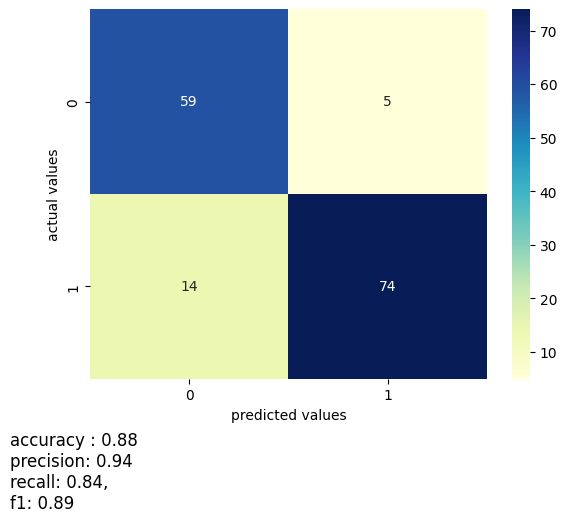

In [38]:
sns.heatmap(confusion_matrix, annot=True, cmap="YlGnBu")

plt.xlabel("predicted values")
plt.ylabel("actual values")
plt.suptitle(f'accuracy : {accuracy:.2f} \nprecision: {precision:.2f} \nrecall: {recall:.2f}, \nf1: {f1:.2f}', y=0, x = 0, horizontalalignment = 'left')

plt.show()

## Árvore de Decisão


In [39]:
resultados = pd.DataFrame(columns = ['size_tree', 'size_leaf', 'error', 'y_pred'])

for size_tree in [1,2,3,4,5,6,7,8,9,10]:
  for size_leaf in [1,2,3,4,5]:
    tree = DecisionTreeClassifier(max_depth = size_tree, min_samples_leaf = size_leaf)
    tree.fit(X_train, y_train)
    y_pred = tree.predict(X_test)

    error = np.sum(np.abs(y_test - y_pred))

    resultados.loc[len(resultados)] = [size_tree, size_leaf, error, y_pred]

resultados = resultados.sort_values(by=['error'], ascending=True)

smallest_error = resultados['error'].iloc[0]
best_pred = resultados['y_pred'].iloc[0]
best_size_tree = resultados['size_tree'].iloc[0]
best_size_leaf = resultados['size_leaf'].iloc[0]

print(f'Best tree size: {best_size_tree} \nBest leaf size: {best_size_leaf} \nSmallest Error: {smallest_error} errors out of {len(best_pred)}, ({smallest_error / len(best_pred) * 100:.2f}% error percentage)')

Best tree size: 2 
Best leaf size: 4 
Smallest Error: 19.0 errors out of 152, (12.50% error percentage)


In [40]:
tree = DecisionTreeClassifier(max_depth = best_size_tree, min_samples_leaf = best_size_leaf)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)

In [41]:
confusion_matrix, accuracy, precision, recall, f1 = metrics(y_pred, y_test)

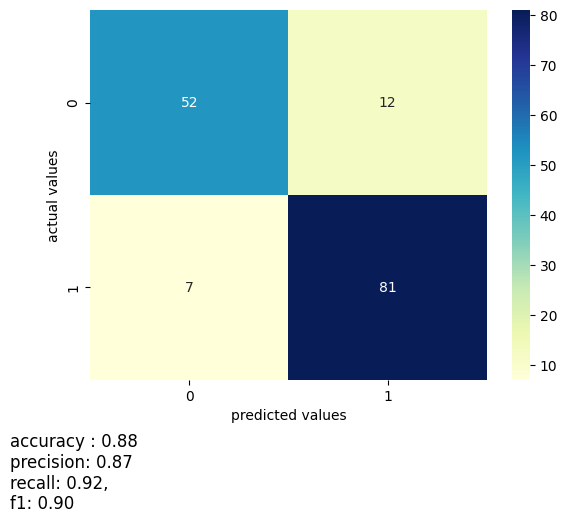

In [42]:
sns.heatmap(confusion_matrix, annot=True, cmap="YlGnBu")

plt.xlabel("predicted values")
plt.ylabel("actual values")
plt.suptitle(f'accuracy : {accuracy:.2f} \nprecision: {precision:.2f} \nrecall: {recall:.2f}, \nf1: {f1:.2f}', y=0, x = 0, horizontalalignment = 'left')

plt.show()